In [1]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import time
import h5py
import srcnn
import torch.optim as optim
import torch.nn as nn
import numpy as np
import math
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torchvision.utils import save_image
matplotlib.style.use('ggplot')

2

In [2]:
# learning parameters
batch_size = 64 # batch size, reduce if facing OOM error
epochs = 100 # number of epochs to train the SRCNN model for
lr = 0.001 # the learning rate
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
# input image dimensions
img_rows, img_cols = 33, 33
out_rows, out_cols = 33, 33

In [5]:
file = h5py.File('../input/train_mscale.h5')
# `in_train` has shape (21884, 33, 33, 1) which corresponds to
# 21884 image patches of 33 pixels height & width and 1 color channel
in_train = file['data'][:] # the training data
out_train = file['label'][:] # the training labels
file.close()
# change the values to float32
in_train = in_train.astype('float32')
out_train = out_train.astype('float32')

In [6]:
(x_train, x_val, y_train, y_val) = train_test_split(in_train, out_train, test_size=0.25)
print('Training samples: ', x_train.shape[0])
print('Validation samples: ', x_val.shape[0])

Training samples:  16368
Validation samples:  5456


In [7]:
# the dataset module
class SRCNNDataset(Dataset):
    def __init__(self, image_data, labels):
        self.image_data = image_data
        self.labels = labels
    def __len__(self):
        return (len(self.image_data))
    def __getitem__(self, index):
        image = self.image_data[index]
        label = self.labels[index]
        return (
            torch.tensor(image, dtype=torch.float),
            torch.tensor(label, dtype=torch.float)
        )

In [8]:
# train and validation data
train_data = SRCNNDataset(x_train, y_train)
val_data = SRCNNDataset(x_val, y_val)
# train and validation loaders
train_loader = DataLoader(train_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)

In [10]:
# initialize the model
print('Computation device: ', device)
model = srcnn.SRCNN().to(device)
print(model)

Computation device:  cpu
SRCNN(
  (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
  (conv3): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
)


In [11]:
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# loss function 
criterion = nn.MSELoss()

In [12]:
def psnr(label, outputs, max_val=1.):
    """
    Compute Peak Signal to Noise Ratio (the higher the better).
    PSNR = 20 * log10(MAXp) - 10 * log10(MSE).
    https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio#Definition
    First we need to convert torch tensors to NumPy operable.
    """
    label = label.cpu().detach().numpy()
    outputs = outputs.cpu().detach().numpy()
    img_diff = outputs - label
    rmse = math.sqrt(np.mean((img_diff) ** 2))
    if rmse == 0:
        return 100
    else:
        PSNR = 20 * math.log10(max_val / rmse)
        return PSNR

In [13]:
def train(model, dataloader):
    model.train()
    running_loss = 0.0
    running_psnr = 0.0
    for bi, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        image_data = data[0].to(device)
        label = data[1].to(device)
        
        # zero grad the optimizer
        optimizer.zero_grad()
        outputs = model(image_data)
        loss = criterion(outputs, label)
        # backpropagation
        loss.backward()
        # update the parameters
        optimizer.step()
        # add loss of each item (total items in a batch = batch size)
        running_loss += loss.item()
        # calculate batch psnr (once every `batch_size` iterations)
        batch_psnr =  psnr(label, outputs)
        running_psnr += batch_psnr
    final_loss = running_loss/len(dataloader.dataset)
    final_psnr = running_psnr/int(len(train_data)/dataloader.batch_size)
    return final_loss, final_psnr

In [14]:
def validate(model, dataloader, epoch):
    model.eval()
    running_loss = 0.0
    running_psnr = 0.0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            image_data = data[0].to(device)
            label = data[1].to(device)
            
            outputs = model(image_data)
            loss = criterion(outputs, label)
            # add loss of each item (total items in a batch = batch size) 
            running_loss += loss.item()
            # calculate batch psnr (once every `batch_size` iterations)
            batch_psnr = psnr(label, outputs)
            running_psnr += batch_psnr
        outputs = outputs.cpu()
        save_image(outputs, f"../outputs/val_sr{epoch}.png")
    final_loss = running_loss/len(dataloader.dataset)
    final_psnr = running_psnr/int(len(val_data)/dataloader.batch_size)
    return final_loss, final_psnr

In [15]:
train_loss, val_loss = [], []
train_psnr, val_psnr = [], []
start = time.time()
for epoch in range(epochs):
    print(f"Epoch {epoch + 1} of {epochs}")
    train_epoch_loss, train_epoch_psnr = train(model, train_loader)
    val_epoch_loss, val_epoch_psnr = validate(model, val_loader, epoch)
    print(f"Train PSNR: {train_epoch_psnr:.3f}")
    print(f"Val PSNR: {val_epoch_psnr:.3f}")
    train_loss.append(train_epoch_loss)
    train_psnr.append(train_epoch_psnr)
    val_loss.append(val_epoch_loss)
    val_psnr.append(val_epoch_psnr)
end = time.time()
print(f"Finished training in: {((end-start)/60):.3f} minutes")

Epoch 1 of 100


256it [00:22, 11.26it/s]                                                        
86it [00:02, 35.18it/s]                                                         


Train PSNR: 24.393
Val PSNR: 26.564
Epoch 2 of 100


256it [00:23, 11.10it/s]                                                        
86it [00:02, 32.56it/s]                                                         


Train PSNR: 26.649
Val PSNR: 26.976
Epoch 3 of 100


256it [00:21, 11.82it/s]                                                        
86it [00:02, 36.01it/s]                                                         


Train PSNR: 26.927
Val PSNR: 27.169
Epoch 4 of 100


256it [00:30,  8.31it/s]                                                        
86it [00:02, 30.34it/s]                                                         


Train PSNR: 27.059
Val PSNR: 27.285
Epoch 5 of 100


256it [00:22, 11.44it/s]                                                        
86it [00:02, 35.59it/s]                                                         


Train PSNR: 27.139
Val PSNR: 27.351
Epoch 6 of 100


256it [00:22, 11.14it/s]                                                        
86it [00:02, 36.13it/s]                                                         


Train PSNR: 27.196
Val PSNR: 27.400
Epoch 7 of 100


256it [00:22, 11.41it/s]                                                        
86it [00:02, 36.14it/s]                                                         


Train PSNR: 27.231
Val PSNR: 27.412
Epoch 8 of 100


256it [00:22, 11.38it/s]                                                        
86it [00:02, 35.94it/s]                                                         


Train PSNR: 27.273
Val PSNR: 27.447
Epoch 9 of 100


256it [00:22, 11.41it/s]                                                        
86it [00:02, 35.40it/s]                                                         


Train PSNR: 27.297
Val PSNR: 27.484
Epoch 10 of 100


256it [00:22, 11.28it/s]                                                        
86it [00:02, 35.95it/s]                                                         


Train PSNR: 27.318
Val PSNR: 27.502
Epoch 11 of 100


256it [00:22, 11.54it/s]                                                        
86it [00:02, 35.71it/s]                                                         


Train PSNR: 27.336
Val PSNR: 27.526
Epoch 12 of 100


256it [00:25, 10.08it/s]                                                        
86it [00:02, 35.43it/s]                                                         


Train PSNR: 27.364
Val PSNR: 27.553
Epoch 13 of 100


256it [00:22, 11.43it/s]                                                        
86it [00:02, 36.01it/s]                                                         


Train PSNR: 27.372
Val PSNR: 27.576
Epoch 14 of 100


256it [00:27,  9.35it/s]                                                        
86it [00:02, 36.09it/s]                                                         


Train PSNR: 27.385
Val PSNR: 27.572
Epoch 15 of 100


256it [00:25,  9.97it/s]                                                        
86it [00:03, 26.27it/s]                                                         


Train PSNR: 27.406
Val PSNR: 27.577
Epoch 16 of 100


256it [00:24, 10.47it/s]                                                        
86it [00:02, 36.17it/s]                                                         


Train PSNR: 27.416
Val PSNR: 27.623
Epoch 17 of 100


256it [00:24, 10.31it/s]                                                        
86it [00:02, 30.16it/s]                                                         


Train PSNR: 27.436
Val PSNR: 27.642
Epoch 18 of 100


256it [00:22, 11.24it/s]                                                        
86it [00:02, 35.38it/s]                                                         


Train PSNR: 27.458
Val PSNR: 27.630
Epoch 19 of 100


256it [00:25,  9.85it/s]                                                        
86it [00:02, 35.93it/s]                                                         


Train PSNR: 27.466
Val PSNR: 27.602
Epoch 20 of 100


256it [00:22, 11.31it/s]                                                        
86it [00:02, 29.77it/s]                                                         


Train PSNR: 27.474
Val PSNR: 27.602
Epoch 21 of 100


256it [00:25, 10.03it/s]                                                        
86it [00:02, 34.47it/s]                                                         


Train PSNR: 27.486
Val PSNR: 27.648
Epoch 22 of 100


256it [00:24, 10.56it/s]                                                        
86it [00:02, 29.94it/s]                                                         


Train PSNR: 27.508
Val PSNR: 27.697
Epoch 23 of 100


256it [00:24, 10.48it/s]                                                        
86it [00:02, 36.18it/s]                                                         


Train PSNR: 27.508
Val PSNR: 27.679
Epoch 24 of 100


256it [00:26,  9.78it/s]                                                        
86it [00:02, 35.10it/s]                                                         


Train PSNR: 27.529
Val PSNR: 27.714
Epoch 25 of 100


256it [00:22, 11.58it/s]                                                        
86it [00:02, 34.32it/s]                                                         


Train PSNR: 27.532
Val PSNR: 27.727
Epoch 26 of 100


256it [00:27,  9.24it/s]                                                        
86it [00:02, 32.50it/s]                                                         


Train PSNR: 27.543
Val PSNR: 27.714
Epoch 27 of 100


256it [00:22, 11.56it/s]                                                        
86it [00:02, 35.82it/s]                                                         


Train PSNR: 27.553
Val PSNR: 27.685
Epoch 28 of 100


256it [00:28,  9.07it/s]                                                        
86it [00:02, 30.14it/s]                                                         


Train PSNR: 27.571
Val PSNR: 27.750
Epoch 29 of 100


256it [00:22, 11.45it/s]                                                        
86it [00:02, 35.54it/s]                                                         


Train PSNR: 27.568
Val PSNR: 27.670
Epoch 30 of 100


256it [00:27,  9.42it/s]                                                        
86it [00:02, 30.05it/s]                                                         


Train PSNR: 27.594
Val PSNR: 27.756
Epoch 31 of 100


256it [00:22, 11.34it/s]                                                        
86it [00:02, 29.41it/s]                                                         


Train PSNR: 27.600
Val PSNR: 27.765
Epoch 32 of 100


256it [00:27,  9.33it/s]                                                        
86it [00:02, 35.51it/s]                                                         


Train PSNR: 27.609
Val PSNR: 27.732
Epoch 33 of 100


256it [00:24, 10.33it/s]                                                        
86it [00:02, 30.12it/s]                                                         


Train PSNR: 27.599
Val PSNR: 27.718
Epoch 34 of 100


256it [00:25, 10.03it/s]                                                        
86it [00:02, 34.87it/s]                                                         


Train PSNR: 27.626
Val PSNR: 27.765
Epoch 35 of 100


256it [00:23, 10.75it/s]                                                        
86it [00:02, 29.47it/s]                                                         


Train PSNR: 27.645
Val PSNR: 27.802
Epoch 36 of 100


256it [00:26,  9.82it/s]                                                        
86it [00:02, 35.83it/s]                                                         


Train PSNR: 27.655
Val PSNR: 27.805
Epoch 37 of 100


256it [00:24, 10.30it/s]                                                        
86it [00:02, 30.11it/s]                                                         


Train PSNR: 27.669
Val PSNR: 27.875
Epoch 38 of 100


256it [00:24, 10.29it/s]                                                        
86it [00:02, 36.08it/s]                                                         


Train PSNR: 27.673
Val PSNR: 27.627
Epoch 39 of 100


256it [00:25,  9.93it/s]                                                        
86it [00:02, 29.67it/s]                                                         


Train PSNR: 27.676
Val PSNR: 27.554
Epoch 40 of 100


256it [00:25, 10.06it/s]                                                        
86it [00:02, 35.15it/s]                                                         


Train PSNR: 27.686
Val PSNR: 27.806
Epoch 41 of 100


256it [00:27,  9.35it/s]                                                        
86it [00:02, 34.09it/s]                                                         


Train PSNR: 27.698
Val PSNR: 27.771
Epoch 42 of 100


256it [00:24, 10.65it/s]                                                        
86it [00:02, 29.07it/s]                                                         


Train PSNR: 27.701
Val PSNR: 27.913
Epoch 43 of 100


256it [00:25,  9.85it/s]                                                        
86it [00:02, 35.25it/s]                                                         


Train PSNR: 27.725
Val PSNR: 27.907
Epoch 44 of 100


256it [00:24, 10.25it/s]                                                        
86it [00:03, 28.53it/s]                                                         


Train PSNR: 27.730
Val PSNR: 27.956
Epoch 45 of 100


256it [00:26,  9.68it/s]                                                        
86it [00:02, 35.35it/s]                                                         


Train PSNR: 27.736
Val PSNR: 27.295
Epoch 46 of 100


256it [00:25, 10.05it/s]                                                        
86it [00:02, 29.19it/s]                                                         


Train PSNR: 27.743
Val PSNR: 27.203
Epoch 47 of 100


256it [00:25, 10.06it/s]                                                        
86it [00:02, 35.69it/s]                                                         


Train PSNR: 27.765
Val PSNR: 27.979
Epoch 48 of 100


256it [00:25, 10.18it/s]                                                        
86it [00:02, 30.03it/s]                                                         


Train PSNR: 27.768
Val PSNR: 27.963
Epoch 49 of 100


256it [00:25,  9.95it/s]                                                        
86it [00:02, 33.12it/s]                                                         


Train PSNR: 27.769
Val PSNR: 27.451
Epoch 50 of 100


256it [00:26,  9.59it/s]                                                        
86it [00:02, 30.04it/s]                                                         


Train PSNR: 27.769
Val PSNR: 27.969
Epoch 51 of 100


256it [00:23, 10.93it/s]                                                        
86it [00:02, 29.61it/s]                                                         


Train PSNR: 27.763
Val PSNR: 28.015
Epoch 52 of 100


256it [00:27,  9.23it/s]                                                        
86it [00:02, 30.35it/s]                                                         


Train PSNR: 27.798
Val PSNR: 27.981
Epoch 53 of 100


256it [00:24, 10.54it/s]                                                        
86it [00:02, 29.92it/s]                                                         


Train PSNR: 27.759
Val PSNR: 28.056
Epoch 54 of 100


256it [00:26,  9.83it/s]                                                        
86it [00:02, 34.91it/s]                                                         


Train PSNR: 27.820
Val PSNR: 28.066
Epoch 55 of 100


256it [00:25,  9.91it/s]                                                        
86it [00:02, 30.43it/s]                                                         


Train PSNR: 27.807
Val PSNR: 28.006
Epoch 56 of 100


256it [00:24, 10.63it/s]                                                        
86it [00:02, 32.23it/s]                                                         


Train PSNR: 27.823
Val PSNR: 28.033
Epoch 57 of 100


256it [00:27,  9.20it/s]                                                        
86it [00:02, 30.29it/s]                                                         


Train PSNR: 27.812
Val PSNR: 28.003
Epoch 58 of 100


256it [00:23, 10.83it/s]                                                        
86it [00:02, 36.05it/s]                                                         


Train PSNR: 27.801
Val PSNR: 28.032
Epoch 59 of 100


256it [00:27,  9.48it/s]                                                        
86it [00:02, 30.00it/s]                                                         


Train PSNR: 27.855
Val PSNR: 28.084
Epoch 60 of 100


256it [00:25,  9.85it/s]                                                        
86it [00:02, 36.11it/s]                                                         


Train PSNR: 27.809
Val PSNR: 27.907
Epoch 61 of 100


256it [00:26,  9.72it/s]                                                        
86it [00:02, 29.67it/s]                                                         


Train PSNR: 27.859
Val PSNR: 28.099
Epoch 62 of 100


256it [00:27,  9.41it/s]                                                        
86it [00:02, 31.62it/s]                                                         


Train PSNR: 27.844
Val PSNR: 27.925
Epoch 63 of 100


256it [00:25,  9.99it/s]                                                        
86it [00:02, 32.37it/s]                                                         


Train PSNR: 27.835
Val PSNR: 28.011
Epoch 64 of 100


256it [00:25, 10.01it/s]                                                        
86it [00:02, 32.70it/s]                                                         


Train PSNR: 27.845
Val PSNR: 28.120
Epoch 65 of 100


256it [00:25,  9.96it/s]                                                        
86it [00:02, 30.89it/s]                                                         


Train PSNR: 27.889
Val PSNR: 28.004
Epoch 66 of 100


256it [00:25,  9.91it/s]                                                        
86it [00:02, 32.61it/s]                                                         


Train PSNR: 27.885
Val PSNR: 28.145
Epoch 67 of 100


256it [00:25, 10.03it/s]                                                        
86it [00:02, 32.16it/s]                                                         


Train PSNR: 27.887
Val PSNR: 26.800
Epoch 68 of 100


256it [00:25,  9.96it/s]                                                        
86it [00:02, 32.07it/s]                                                         


Train PSNR: 27.855
Val PSNR: 27.969
Epoch 69 of 100


256it [00:25,  9.92it/s]                                                        
86it [00:02, 32.30it/s]                                                         


Train PSNR: 27.881
Val PSNR: 28.053
Epoch 70 of 100


256it [00:25,  9.97it/s]                                                        
86it [00:02, 30.42it/s]                                                         


Train PSNR: 27.894
Val PSNR: 28.169
Epoch 71 of 100


256it [00:26,  9.62it/s]                                                        
86it [00:02, 32.68it/s]                                                         


Train PSNR: 27.912
Val PSNR: 28.046
Epoch 72 of 100


256it [00:25,  9.94it/s]                                                        
86it [00:02, 31.45it/s]                                                         


Train PSNR: 27.940
Val PSNR: 28.152
Epoch 73 of 100


256it [00:25,  9.96it/s]                                                        
86it [00:02, 31.97it/s]                                                         


Train PSNR: 27.895
Val PSNR: 27.952
Epoch 74 of 100


256it [00:30,  8.37it/s]                                                        
86it [00:02, 32.23it/s]                                                         


Train PSNR: 27.931
Val PSNR: 28.169
Epoch 75 of 100


256it [00:24, 10.32it/s]                                                        
86it [00:02, 32.72it/s]                                                         


Train PSNR: 27.911
Val PSNR: 28.127
Epoch 76 of 100


256it [00:24, 10.34it/s]                                                        
86it [00:02, 31.86it/s]                                                         


Train PSNR: 27.928
Val PSNR: 28.194
Epoch 77 of 100


256it [00:27,  9.27it/s]                                                        
86it [00:02, 29.92it/s]                                                         


Train PSNR: 27.934
Val PSNR: 28.194
Epoch 78 of 100


256it [00:24, 10.29it/s]                                                        
86it [00:02, 33.26it/s]                                                         


Train PSNR: 27.788
Val PSNR: 27.910
Epoch 79 of 100


256it [00:26,  9.84it/s]                                                        
86it [00:02, 34.12it/s]                                                         


Train PSNR: 27.888
Val PSNR: 27.971
Epoch 80 of 100


256it [00:26,  9.58it/s]                                                        
86it [00:02, 31.19it/s]                                                         


Train PSNR: 27.938
Val PSNR: 27.395
Epoch 81 of 100


256it [00:24, 10.47it/s]                                                        
86it [00:02, 34.38it/s]                                                         


Train PSNR: 27.910
Val PSNR: 27.961
Epoch 82 of 100


256it [00:24, 10.45it/s]                                                        
86it [00:02, 32.96it/s]                                                         


Train PSNR: 27.970
Val PSNR: 28.219
Epoch 83 of 100


256it [00:24, 10.37it/s]                                                        
86it [00:02, 34.06it/s]                                                         


Train PSNR: 27.957
Val PSNR: 28.195
Epoch 84 of 100


256it [00:23, 10.99it/s]                                                        
86it [00:02, 37.86it/s]                                                         


Train PSNR: 27.943
Val PSNR: 28.170
Epoch 85 of 100


256it [00:24, 10.40it/s]                                                        
86it [00:02, 29.65it/s]                                                         


Train PSNR: 27.971
Val PSNR: 28.050
Epoch 86 of 100


256it [00:27,  9.15it/s]                                                        
86it [00:02, 29.51it/s]                                                         


Train PSNR: 27.988
Val PSNR: 28.224
Epoch 87 of 100


256it [00:27,  9.18it/s]                                                        
86it [00:02, 29.88it/s]                                                         


Train PSNR: 27.948
Val PSNR: 27.997
Epoch 88 of 100


256it [00:23, 10.76it/s]                                                        
86it [00:02, 30.17it/s]                                                         


Train PSNR: 28.002
Val PSNR: 28.186
Epoch 89 of 100


256it [00:27,  9.27it/s]                                                        
86it [00:02, 29.81it/s]                                                         


Train PSNR: 27.950
Val PSNR: 28.251
Epoch 90 of 100


256it [00:25, 10.23it/s]                                                        
86it [00:02, 34.61it/s]                                                         


Train PSNR: 27.994
Val PSNR: 28.253
Epoch 91 of 100


256it [00:27,  9.43it/s]                                                        
86it [00:03, 28.51it/s]                                                         


Train PSNR: 27.981
Val PSNR: 28.022
Epoch 92 of 100


256it [00:26,  9.52it/s]                                                        
86it [00:02, 36.03it/s]                                                         


Train PSNR: 27.979
Val PSNR: 28.250
Epoch 93 of 100


256it [00:24, 10.27it/s]                                                        
86it [00:02, 29.59it/s]                                                         


Train PSNR: 28.008
Val PSNR: 28.273
Epoch 94 of 100


256it [00:30,  8.41it/s]                                                        
86it [00:02, 29.31it/s]                                                         


Train PSNR: 28.013
Val PSNR: 28.244
Epoch 95 of 100


256it [00:29,  8.79it/s]                                                        
86it [00:02, 29.14it/s]                                                         


Train PSNR: 28.005
Val PSNR: 28.261
Epoch 96 of 100


256it [00:22, 11.13it/s]                                                        
86it [00:02, 38.16it/s]                                                         


Train PSNR: 27.982
Val PSNR: 28.140
Epoch 97 of 100


256it [00:24, 10.26it/s]                                                        
86it [00:02, 32.33it/s]                                                         


Train PSNR: 28.007
Val PSNR: 28.191
Epoch 98 of 100


256it [00:25, 10.05it/s]                                                        
86it [00:02, 38.12it/s]                                                         


Train PSNR: 28.027
Val PSNR: 28.112
Epoch 99 of 100


256it [00:23, 10.94it/s]                                                        
86it [00:02, 31.75it/s]                                                         


Train PSNR: 28.012
Val PSNR: 28.284
Epoch 100 of 100


256it [00:24, 10.29it/s]                                                        
86it [00:02, 38.20it/s]                                                         

Train PSNR: 28.018
Val PSNR: 28.234
Finished training in: 46.561 minutes


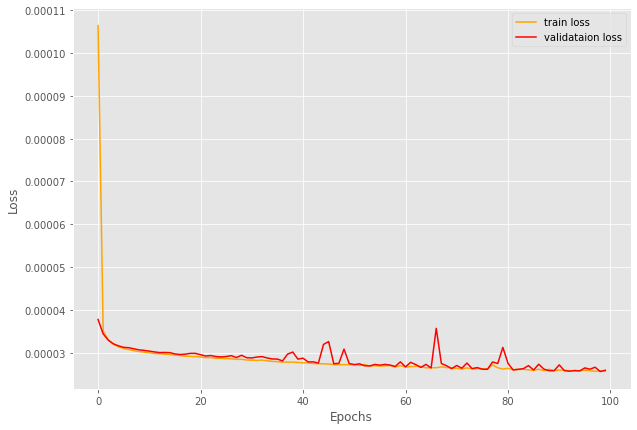

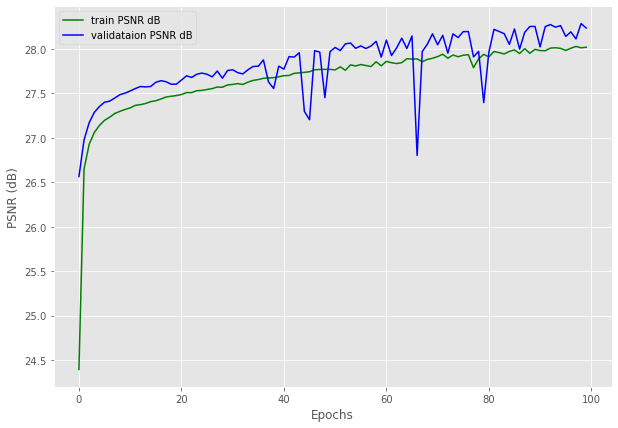

Saving model...


In [16]:
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('../outputs/loss.png')
plt.show()
# psnr plots
plt.figure(figsize=(10, 7))
plt.plot(train_psnr, color='green', label='train PSNR dB')
plt.plot(val_psnr, color='blue', label='validataion PSNR dB')
plt.xlabel('Epochs')
plt.ylabel('PSNR (dB)')
plt.legend()
plt.savefig('../outputs/psnr.png')
plt.show()
# save the model to disk
print('Saving model...')
torch.save(model.state_dict(), '../outputs/model.pth')


In [17]:
device

'cpu'